In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scripts.utils import load_csv, split_date, drop_columns, impute_rolling_median, add_seasonality, create_lags, apply_moving_average_for_roc, split_data_frame, create_sequences, simplify_df, trigonometric_date_encoding
from dotenv import load_dotenv
import os

from statsmodels.tsa.arima.model import ARIMA

In [21]:
df = load_csv('../data/btc_timeseries.csv')
df = split_date(df, 'time')
df = simplify_df(df)
df = drop_columns(df, 10.0)
df = impute_rolling_median(df, 5)
df = add_seasonality(df)
df = apply_moving_average_for_roc(df, 'ema', 10, 20)
df = df.ffill()

/Users/lucapetracca/Documents/GitHub/Transformers-Financial-Time-Series-Forecasting/models/scripts/utils.py:153: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='bfill', inplace=True)  # Backfill to address initial NaNs


In [22]:
df.set_index('time', inplace=True)
monthly_df = df['close'].resample('M').mean()

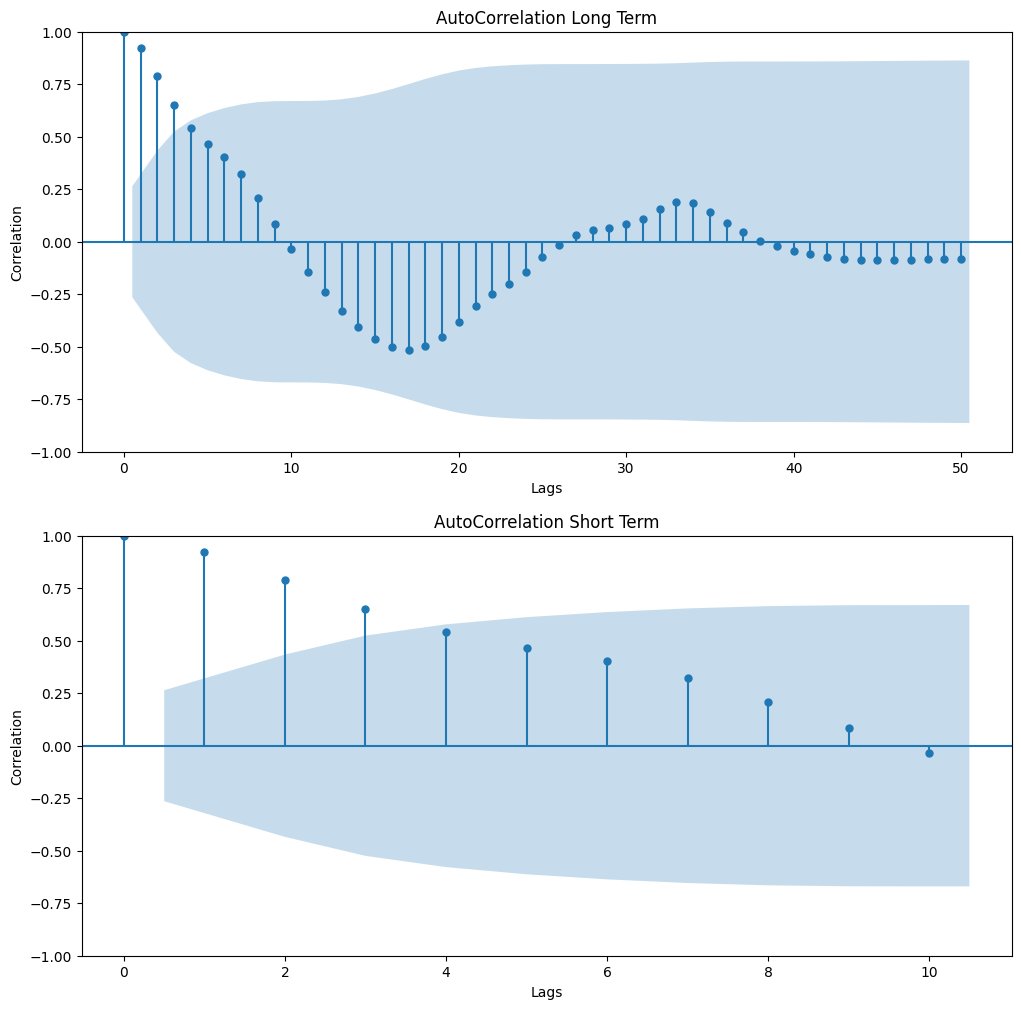

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 12))

# AutoCorrelation for Long Term
acf = plot_acf(monthly_df, lags=50, ax=ax1)
ax1.set_title('AutoCorrelation Long Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')

# AutoCorrelation for Short Term
acf = plot_acf(monthly_df, lags=10, ax=ax2)
ax2.set_title('AutoCorrelation Short Term')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

plt.show()

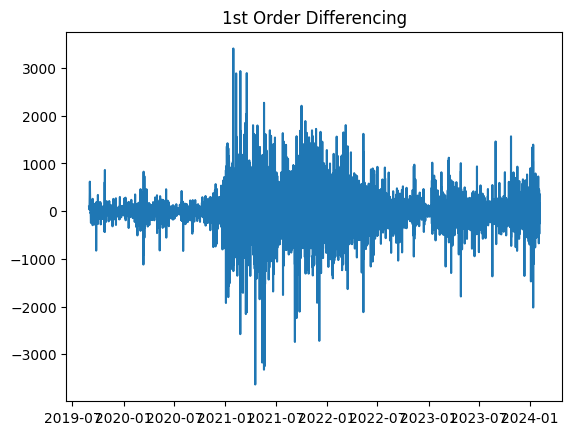

In [24]:
f = plt.figure()
ax1 = f.add_subplot(111)
ax1.set_title('1st Order Differencing')
ax1.plot(df.close.diff())

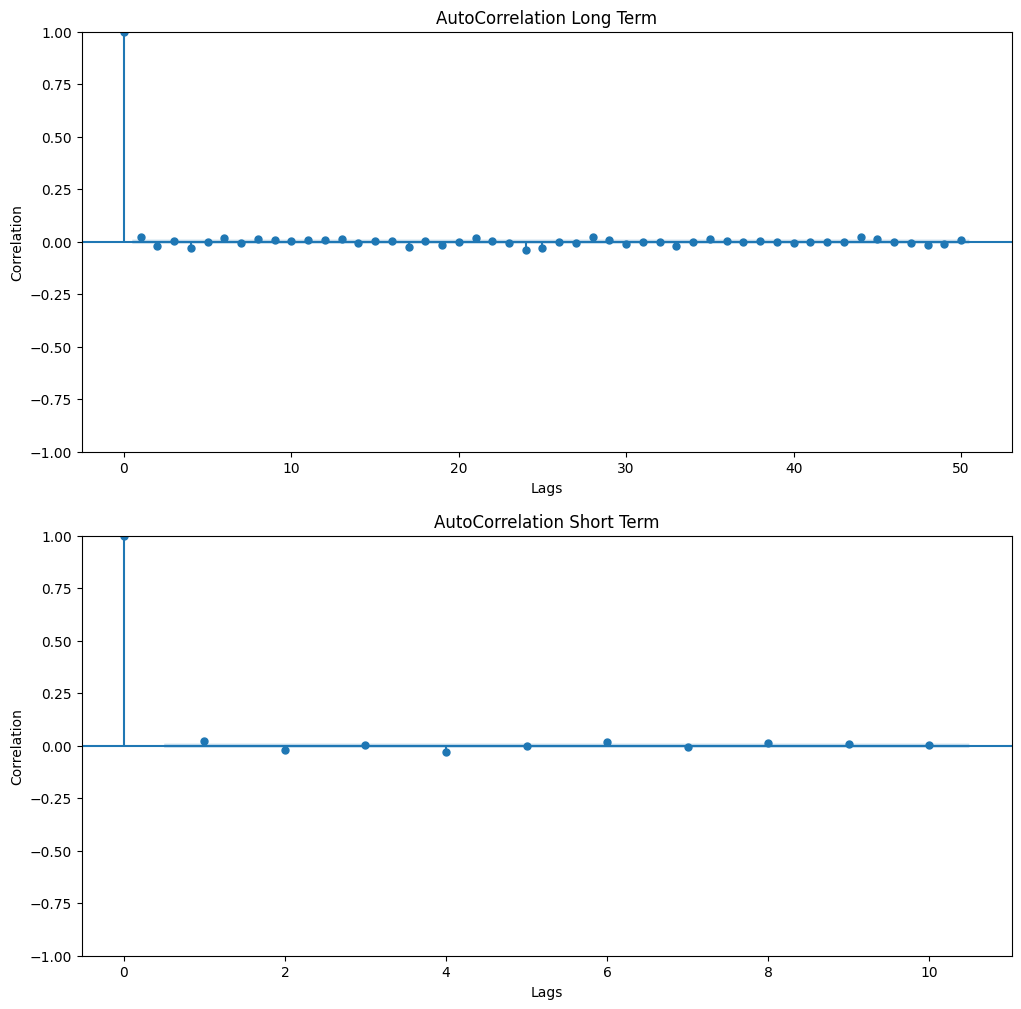

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 12))

# AutoCorrelation for Long Term
acf = plot_acf(df.close.diff().dropna(), lags=50, ax=ax1)
ax1.set_title('AutoCorrelation Long Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')

# AutoCorrelation for Short Term
acf = plot_acf(df.close.diff().dropna(), lags=10, ax=ax2)
ax2.set_title('AutoCorrelation Short Term')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

plt.show()

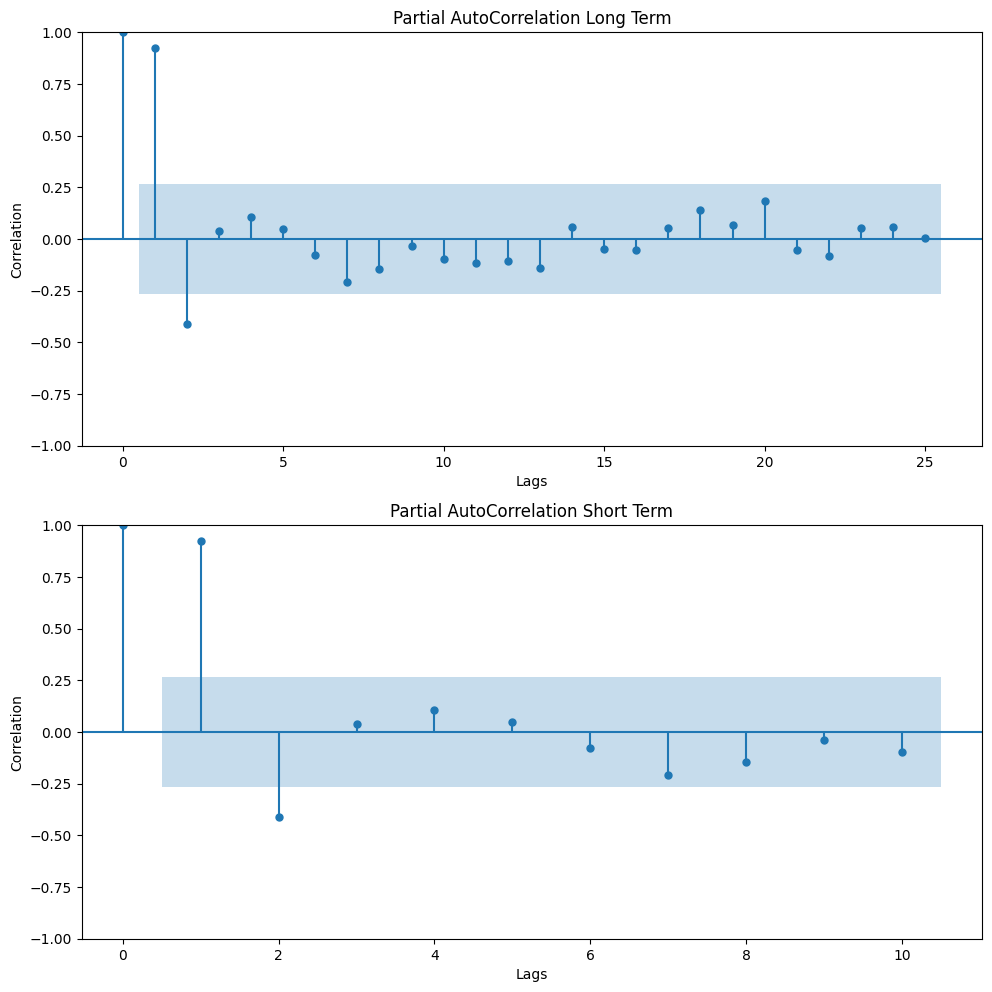

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

# Partial AutoCorrelation for Long Term
pacf = plot_pacf(monthly_df, lags=25, ax=ax1)
ax1.set_title('Partial AutoCorrelation Long Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')

# Partial AutoCorrelation for Short Term
pacf = plot_pacf(monthly_df, lags=10, ax=ax2)
ax2.set_title('Partial AutoCorrelation Short Term')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

plt.tight_layout(pad=1)
plt.show()

In [27]:
from statsmodels.tsa.stattools import adfuller, kpss

def ADF_check(column):
    result = adfuller(column.dropna())  # Drop NA values if present
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
ADF_check(df.close)
ADF_check(df.close.diff())

ADF Statistic: -1.423434
p-value: 0.570992
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
ADF Statistic: -27.777032
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [28]:
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'Num Lags: {n_lags}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df.close)

KPSS Statistic: 8.084538649061786
p-value: 0.01
Num Lags: 116
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/var/folders/4x/xdz4xz_d7c59926x0c2wps4m0000gn/T/ipykernel_76017/1610268620.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


In [29]:
close_diff = df.close.diff()

if close_diff.isnull().any():
    close_diff.bfill(inplace=True)

kpss_test(close_diff)

KPSS Statistic: 0.10836901604230997
p-value: 0.1
Num Lags: 18
Critical Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/var/folders/4x/xdz4xz_d7c59926x0c2wps4m0000gn/T/ipykernel_76017/1610268620.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


In [30]:
df['close_diff'] = df['close'].diff() 
if df['close_diff'].isnull().any():
    df['close_diff'].bfill(inplace=True)

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Split the data into train and test
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['close_diff'], order=(1, 0, 1))
model_train_fit = model_train.fit()

# Print model summary
print(model_train_fit.summary())

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)
if test_forecast_series.isnull().any():
    test_forecast_series.ffill(inplace=True)

# Calculate the mean squared error
mse = mean_squared_error(test['close_diff'], test_forecast_series)
rmse = mse**0.5
mae = mean_absolute_error(test['close_diff'], test_forecast_series)

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['close_diff'], label='Training Data')
plt.plot(test['close_diff'], label='Test Data', color='orange')  # Make sure label matches dataframe
plt.plot(test_forecast_series, label='Predictions', color='green')
plt.fill_between(test.index,
                 test_forecast.conf_int().iloc[:, 0],
                 test_forecast.conf_int().iloc[:, 1],
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)

/Users/lucapetracca/anaconda3/envs/dmts/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucapetracca/anaconda3/envs/dmts/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lucapetracca/anaconda3/envs/dmts/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             close_diff   No. Observations:                30924
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -213628.513
Date:                Tue, 23 Apr 2024   AIC                         427265.026
Time:                        15:19:51   BIC                         427298.383
Sample:                             0   HQIC                        427275.714
                              - 30924                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5824      1.421      0.410      0.682      -2.203       3.367
ar.L1         -0.5725      0.041    -13.848      0.000      -0.653      -0.491
ma.L1          0.6070      0.040     15.049      0.0

/Users/lucapetracca/anaconda3/envs/dmts/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/lucapetracca/anaconda3/envs/dmts/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ValueError: Input contains NaN.

In [ ]:
model_train_fit.plot_diagnostics(figsize=(15, 12))
plt.show()